# The Agent-Environment Interaction: Getting Started

This notebook presents _one possible_ approach to get you started in the agent-environment interaction exercise. You are highly encouraged to make your own decisions and deviate from this template - the more you do on your own, the more you will learn.

## General structure

We want to implement the agent-environment interface depicted in the exercise sheet. We need
* an **agent** with a random policy,
* an **environment**,
* and a procedure that lets the agent interact within the environment.

We will build each of these components incrementally and components as they are needed. We make the choice of defining a **class** for both the agent and the environment. 

For the learning procedure itself, we would eventually organise the code in a double (nested) loop; the outer one for episodes, and the inner one for steps within each episode. However, we will start looking at just **one single step**. In this step, we need to
1. observe the current state of the environment,
2. let the agent choose an action, and
3. let the environment respond by changing its state and returning a reward.

Written differently for one time step `t`, we need:

In [15]:
# state_t = environment.get_current_state()
# action_t = agent.choose_action(state_t)
# reward_t, state_t_plus_1 = environment.make_step(action_t)

We thus need an agent with a `choose_action(state_t)` method.
And we need an environment with a `get_current_state()` method and a `make_step(action_t)` method.

### The environment: a `Gridworld` class

We will distinguish between the internal state of the environment, which is hidden from the agent and the interface, and the external state, which corresponds to all the parts that are accessible to the agent. For example, we do not want the agent to know where the bomb is, but the agent has to know which actions are available.

#### The internal state of the environment
The Gridworld class has to keep track of
* the general properties of the environment, e.g., the available actions or the number of cells
* the positions of the agent, and both terminal states: the gold and the bomb
* the rewards for each cell

In order to keep things simple, we will implement a very unflexible version of the environment. For example, we will keep the dimensions of the grid, the number of bombs, and the position of the gold fixed. You can (read: should) introduce variables for all these hard-coded properties once your algorithm is working.

Let us first define a class that specifies all 

In [16]:
import numpy as np

class Gridworld:
    def __init__(self):
        self.num_rows = 5
        self.num_cols = 5
        self.num_cells = self.num_cols * self.num_rows
        self.random_move_probability = 0.2
        
        # Choose starting position of the agent randomly among the first 5 cells
        self.agent_position = np.random.randint(0, 5)
        
        # Choose position of the gold and bomb
        self.bomb_positions = np.array([18])
        self.gold_positions = np.array([23])
        self.terminal_states = np.array([self.bomb_positions, self.gold_positions])
       
        # Specify rewards
        self.rewards = np.zeros(self.num_cells)
        self.rewards[self.bomb_positions] = -10
        self.rewards[self.gold_positions] = 10
        
        # Specify available actions
        self.actions = ["UP", "RIGHT", "DOWN", "LEFT"]
        self.num_actions = len(self.actions)
       
    def get_available_actions(self):
        return self.actions

    def make_step(self, action_index): 
        # Randomly sample action_index if world is stochastic
        if np.random.uniform(0, 1) < self.random_move_probability:
            action_indices = np.arange(self.num_actions, dtype=int)
            action_indices = np.delete(action_indices, action_index)
            action_index = np.random.choice(action_indices, 1)[0]

        action = self.actions[action_index]

        # Determine new position and check whether the agent hits a wall.
        old_position = self.agent_position
        new_position = self.agent_position
        if action == "UP":
            candidate_position = old_position + self.num_cols
            if candidate_position < self.num_cells:
                new_position = candidate_position
        elif action == "RIGHT":
            candidate_position = old_position + 1
            if candidate_position % self.num_cols > 0:  # The %-operator denotes "modulo"-division.
                new_position = candidate_position
        elif action == "DOWN":
            candidate_position = old_position - self.num_cols
            if candidate_position >= 0:
                new_position = candidate_position
        elif action == "LEFT":  # "LEFT"
            candidate_position = old_position - 1
            if candidate_position % self.num_cols < self.num_cols - 1:
                new_position = candidate_position
        else:
            raise ValueError('Action was mis-specified!')

        # Update the environment state
        self.agent_position = new_position
        
        # Calculate reward
        reward = self.rewards[self.agent_position]
        reward -= 1
        return reward, new_position


    def reset(self):
        self.agent_position = np.random.randint(0, 5)
    ## Put other methods here:
    # def reset():
    #     ...
    # ...

Note that we chose to specify the cells in a one-dimensional array instead of a two-dimensional array (e.g., the bomb is at position `18` and not at position `[3,3]` in a two-dimensional array). This is a completely personal choice and you could choose either option. 

#### The interface of the environment
We now want to define a method that provides any agent with the needed (and allowed!) information about the current state of the environment.

Take a minute and think about which fields among those we defined above are needed both for the RandomAgent and, later, the Q-learning agent. 

...? You found an answer? Go on.

The RandomAgent only needs the available actions (technically, only the number of available actions) to randomly choose from. The Q-learning agent will need the available actions _and_ its current position.

Let us for now focus on the random agent and define a method for the Gridworld class that returns the available actions.

### The agent: a `RandomAgent` class

We now define a RandomAgent class with a `choose_action` method.

In [17]:
class RandomAgent():
    def choose_action(self, available_actions):
        number_of_actions = len(available_actions)
        random_action_index = np.random.randint(0, number_of_actions)
        return random_action_index

Let's test the code that we've written so far.

In [18]:
env = Gridworld()
agent = RandomAgent()

available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)

Available_actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
Randomly chosen action = 2


Now that the agent has chosen a random action, we need the environment to respond to that action. Let us define another method for the `Gridworld` class that takes the chosen action as input, updates the internal state of the environment, and returns a reward.



In [19]:
    # Add to Gridworld class definition
    
    #....
    def make_step(self, action_index): 
        # Randomly sample action_index if world is stochastic
        if np.random.uniform(0, 1) < self.random_move_probability:
            action_indices = np.arange(self.num_actions, dtype=int)
            action_indices = np.delete(action_indices, action_index)
            action_index = np.random.choice(action_indices, 1)[0]

        action = self.actions[action_index]

        # Determine new position and check whether the agent hits a wall.
        old_position = self.agent_position
        new_position = self.agent_position
        if action == "UP":
            candidate_position = old_position + self.num_cols
            if candidate_position < self.num_cells:
                new_position = candidate_position
        elif action == "RIGHT":
            candidate_position = old_position + 1
            if candidate_position % self.num_cols > 0:  # The %-operator denotes "modulo"-division.
                new_position = candidate_position
        elif action == "DOWN":
            candidate_position = old_position - self.num_cols
            if candidate_position >= 0:
                new_position = candidate_position
        elif action == "LEFT":  # "LEFT"
            candidate_position = old_position - 1
            if candidate_position % self.num_cols < self.num_cols - 1:
                new_position = candidate_position
        else:
            raise ValueError('Action was mis-specified!')

        # Update the environment state
        self.agent_position = new_position
        
        # Calculate reward
        reward = self.rewards[self.agent_position]
        reward -= 1
        return reward, new_position

    
## You can delete this cell after having updated the Gridworld class

After having updated the Gridworld class with the `make_step` method, create a new Gridworld...

In [20]:
env = Gridworld()

...and execute the following cell multiple times:

In [43]:
print("Current position of the agent =", env.agent_position)
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.agent_position)

Current position of the agent = 22
Available_actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
Randomly chosen action = 1
Reward obtained = (9.0, 23)
Current position of the agent = 23


You can now manually walk the RandomAgent through our gridworld!

Next steps include:
* Build a loop so that you do not have to manually move the agent.
* Define a new class that implements a Q-learning Agent
* ...

In [46]:
rewards=np.zeros(100)
env = Gridworld()
agent = RandomAgent()
for i in range(100):
    while env.agent_position not in env.terminal_states:
        available_actions = env.get_available_actions()
        chosen_action = agent.choose_action(available_actions)
        reward, new_position = env.make_step(chosen_action)
        rewards[i]=rewards[i]+reward
        env.agent_position = new_position
    env.reset()
print(rewards)

[ -43.  -73.  -40.  -80.  -29.  -37.  -35.  -52.  -23.  -41.  -45. -100.
  -28. -123.  -14.  -73.  -33.  -65.  -38.  -91.  -55.   -5.  -40.  -33.
  -29.  -48.  -44.  -16.  -71.  -77. -132.  -21.  -46.  -26.  -27. -204.
 -122.  -29.  -37.  -40.  -22.  -22.  -16.  -51.  -28. -172.  -68.  -36.
  -49.  -39.  -42. -259.   -2.   -3.  -44.  -29.  -18. -153. -204. -144.
  -19.  -26.  -73.  -87.  -25.  -22.  -51.  -36.  -18.  -35.  -64.  -40.
  -10. -133.  -11.  -31.  -66.  -91.  -25.  -52.  -24.  -37.  -48.  -58.
  -74.  -27.  -89. -125.  -15.  -72.  -69.  -23.  -23.  -18.  -57.  -21.
  -73.  -51.  -72.  -28.]


## Q-Learning agent

In [110]:
class QAgent:
    def __init__(self):
        self.q_table = np.zeros((25, 4))
        self.alpha = 0.1
        self.gamma = 1
        self.epsilon = 0.05

    def choose_random_action(self, available_actions):
        number_of_actions = len(available_actions)
        random_action_index = np.random.randint(0, number_of_actions)
        return random_action_index
    def choose_greedy_action(self,state, available_actions):
        action_reward= -np.inf
        number_of_actions = len(available_actions)
        for action in range(number_of_actions):
            if self.q_table[state,action]>action_reward:
                action_reward=self.q_table[state,action]
                greedy_action_index=action
        return greedy_action_index
    def update_q_table(self, state, action, reward, new_state):
        self.q_table[state, action] +=self.alpha * (reward + self.gamma * np.max(self.q_table[new_state, :]) - self.q_table[state, action])
    def print_q_table(self):
        print(self.q_table)

In [109]:
qlisto=QAgent()
env=Gridworld()

In [108]:
posi_actual=env.agent_position
print("Agente en =", posi_actual)
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
if np.random.uniform(0, 1) < qlisto.epsilon:
    action_index = qlisto.choose_random_action(available_actions)
else:
    action_index = qlisto.choose_greedy_action(posi_actual, available_actions)
print("chosen action =", action_index)
reward = env.make_step(action_index)
print("Reward obtained =", reward)
print("Current position of the agent =", env.agent_position)
qlisto.update_q_table(posi_actual, action_index, reward[0], env.agent_position)
posi_actual=env.agent_position



Agente en = 2
Available_actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
chosen action = 0
Reward obtained = (-1.0, 1)
Current position of the agent = 1


In [113]:
qlisto=QAgent()
env=Gridworld()
undisc_return=np.zeros(500)
for i in range(500):
    while env.agent_position not in env.terminal_states:
        posi_actual=env.agent_position
        available_actions = env.get_available_actions()
        if np.random.uniform(0, 1) < qlisto.epsilon:
            action_index = qlisto.choose_random_action(available_actions)
        else:
            action_index = qlisto.choose_greedy_action(posi_actual, available_actions)
        reward = env.make_step(action_index)
        qlisto.update_q_table(posi_actual, action_index, reward[0], env.agent_position)
        posi_actual=env.agent_position
        undisc_return[i]+=reward[0]
    env.reset()


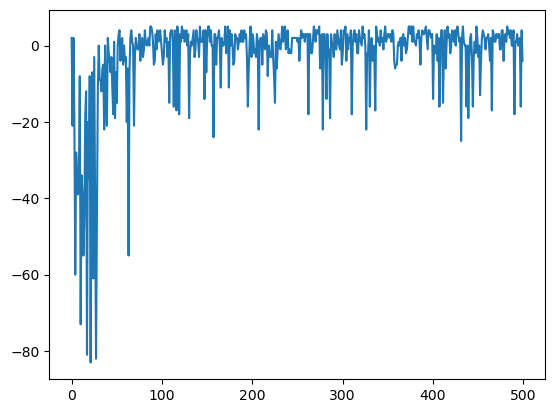

In [114]:
from matplotlib import pyplot as plt
plt.plot(undisc_return)